# 01_Define Area and download OSM Street network

<div class="alert alert-block alert-info"><b>
     
</b>**Here we define an area of interest, retrieve and save an Open Street Map network as a`hdf5` file**
</div>

In [1]:
#load the magic

%matplotlib inline

import os
import sys
from pathlib import Path

import pandana as pdna
from pandana.loaders import osm
import osmnet

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib

In [2]:
path = Path('./')

In [3]:
path_object = (path/'data'/'metropolitan_municipality_cpt.shp')
cpt_shp = gpd.read_file(path_object)

In [4]:
cpt_shp.head(2)

,OBJECTID,CATEGORY,CAT2,CAT_B,MUNICNAME,DISTRICT,PROVINCE,PROVNAME,AREA,SHAPE_LENG,SHAPE_AREA,EA_NUMBER,geometry
0,2,A,Metropolitan Municipality,CPT,City of Cape Town,CPT,WC,Western Cape,2439.78,5.198175,0.238297,Metropolitan Municipality CPT,"MULTIPOLYGON (((18.37075 -33.82018, 18.37030 -..."


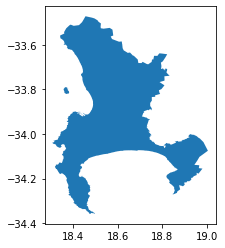

In [5]:
cpt_shp.plot()

In [6]:
cpt_shp.bounds

,minx,miny,maxx,maxy
0,18.30722,-34.35834,19.00467,-33.471276


In [7]:
bbox = (cpt_shp.bounds['minx'][0], cpt_shp.bounds['miny'][0], 
        cpt_shp.bounds['maxx'][0], cpt_shp.bounds['maxy'][0])
bbox

(18.307220001000076,
 -34.35833999699997,
 19.004669996000075,
 -33.47127600399995)

<div class="alert alert-block alert-info"><b>I experienced some challenges with `pdna.loaders.osm.network_from_bbox` and reverted to `osmnet`. 
</b>
</div>

> `network_type=walk` **extracts only OSM walkable street network components.** 
> `two_way=True` **denotes each edge in the network is traversable in both directions with the same weight.**

In [8]:
%%time

#download
network = osmnet.network_from_bbox(bbox=bbox,
                                   network_type='walk',
                                   two_way=True)

#build_network ~ you need to build the network to find disconnected nodes.
network = pdna.Network(network[0]["x"],
                       network[0]["y"], 
                       network[1]["from"], 
                       network[1]["to"], 
                       network[1][["distance"]])

#collect disconnected subgraphs
lcn = network.low_connectivity_nodes(1000, 10, imp_name='distance')

C:\Users\EstelleSK\Anaconda3\lib\site-packages\osmnet\load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
C:\Users\EstelleSK\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](-34.35883647,18.30722000,-33.90822510,18.65417381);>;);out;'}"
Downloaded 57,773.3KB from www.overpass-api.de in 7.15 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](-33.91532432,18.30722000,-33.47127600,18.66620196);>;);out;'}"
Downloaded 29,273.5KB from www.overpass-api.de in 4.70 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestria

In [9]:
#define path
osm_network = 'data/osm2Way_network_CPT_walk.h5'

#save excluding disconnected subgraphs
network.save_hdf5(osm_network, rm_nodes=lcn)
print('OSM data save completed:', osm_network)

OSM data save completed: data/osm2Way_network_CPT_walk.h5


<div class="alert alert-block alert-warning"><b></b>  
    
**What did we download and save?**</div>

In [10]:
%%time

#load
osm_walk_nodes = pd.HDFStore(osm_network).nodes
osm_walk_edges = pd.HDFStore(osm_network).edges

Wall time: 733 ms


In [11]:
osm_walk_nodes.head(5)

,x,y
id,,
18401303,18.858736,-33.932268
18402016,18.878714,-33.929936
18402019,18.879307,-33.932860
18402020,18.879799,-33.933917
18402021,18.879944,-33.934862


In [12]:
osm_walk_edges.head(5)

from          to    distance
18401303 6996959884  18401303  6996959884   13.726407
         6996986085  18401303  6996986085   13.499005
18402016 33023776    18402016    33023776  127.487786
         4259257421  18402016  4259257421  113.191387
18402019 745065331   18402019   745065331  120.937255

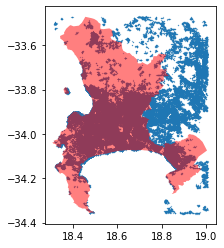

In [28]:
cpt_shp.plot(alpha=0.5, color = 'r', zorder=2)
plt.scatter(x = osm_walk_nodes.x, y = osm_walk_nodes.y, s = 0.05, zorder=1)

In [ ]:
# ancillary code to extract the bbox from suburb
path_object = 'https://citymaps.capetown.gov.za/agsext1/rest/services/Theme_Based/Open_Data_Service/MapServer/75/query?where=1%3D1&outFields=OBJECTID,OFC_SBRB_NAME,SHAPE.STArea()&outSR=4326&f=json'
sub_shp = gpd.read_file(path_object)

In [ ]:
                                    #  example
one = sub_shp[sub_shp.OFC_SBRB_N == "SPRINGFIELD"]
one.plot()
bbox = (one.bounds['minx'][1], one.bounds['miny'][1],
        one.bounds['maxx'][1], one.bounds['maxy'][1])

print(bbox)